<center>
 <font size="5"> <b>This notebook illustrates how to perform linear regression in R </b></font>
</center>

We consider a simple linear regression with one explanatory (regressor) variables $x$ (straight line fit). The response variables are called $y$. The statistical model is:

$$y(x; a, b, \varepsilon) = a x + b + \varepsilon$$

where $\varepsilon$ is the error. We assume that the error follows a normal distribution with mean $0$ and standard deviation $\sigma$:

$$\varepsilon \sim {\cal N}(0, \sigma)$$

The parameters to estimate are the slope $a$ and the intercept $b$. The estimators will be denoted as $\hat{a}$ and $\hat{b}$. The estimation is done by minimizing the sum of squared residuals 

$$\sum_{i=1} \left(y_i - y(x_i; a, b, \varepsilon=0)\right)^2$$

where $y_i$ is the $i^{th}$ measured values of $y$. We also assume that the errors of all measurements are independent. 

The purpose is to see how R can be used to solve this problem, that is find $\hat{a}$ and $\hat{b}$ as well as their covariance matrix. For this, three methods can be used. We will perform calculations for all of them and compare results. Hopefully, we'll find the same results !

In all cases, we consider that the explanatory variable $x$ can take four values ($1$, $2$, $3$ and $4$) and that $\sigma=0.1$. We generate a dataset for $a=2$ and $b=0.4$. 

x,y
1,2.991723
2,4.983081
3,7.260523
4,8.542630


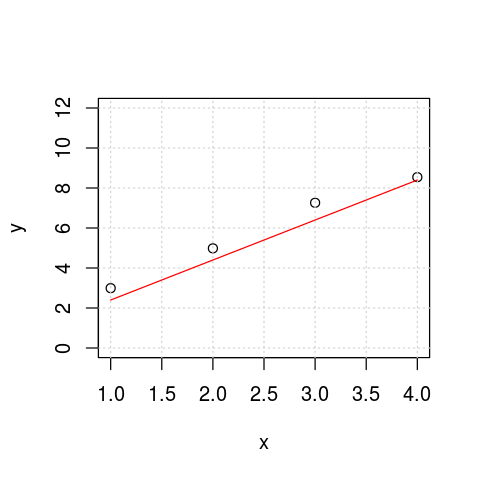

In [16]:
# Set seed to constant value so that results are reproducible
set.seed(1485)

# Create explanatory variable vector
x <- c(1,2,3,4)

# Generate pseudo-data
slope <- 2
intercept <- 0.4
sigma <- 0.6
y <- slope*x + intercept + rnorm(length(x), 0, sigma)

# Make and print datas
ds <- data.frame(x = x, y = y)
ds

# Plot data
options(repr.plot.width=4, repr.plot.height=4) # This sets the size of the plot
plot(y~x, ylim=c(0, 12))
grid()

# Plot true line
lines(x, slopet*x + interceptt, col="red")



#### Method 1: explicit analytical calculation

We know (see lecture notes) that the estimators are given by 

$$\hat{a} = \frac{n\sum_i x_i y_i - \sum_i\sum_j x_i y_j}{n\sum_i x_i^2 - \sum_i\sum_j x_i x_j}$$

and 

$$\hat{b} = \frac{\sum_i\sum_j x_i^2y_j - \sum_i\sum_j x_i y_i x_j}{n\sum_i x_i^2 - \sum_i\sum_j x_i x_j}$$

and that the covariance matrix is given by

$$U=\begin{pmatrix} \sigma_a^2 & cov(a, b)\\cov(a, b) & \sigma_b^2\end{pmatrix} = \frac{\sigma^2}{n\sum_i x_i^2 - \left(\sum_i x_i\right)^2}\begin{pmatrix} n & -\sum_i x_i\\-\sum_i x_i & \sum_i x_i^2\end{pmatrix}$$

Notice that in the expression of $U$, the error standard deviation $\sigma$ appears. In practical cases, we often don't know this value. So, rather than using the unknown true value we use an estimator:

$$\hat{\sigma^2} = \frac{\sum_i \left(y_i - \hat{y}_i\right)^2}{n-2}$$

where $\hat{y}_i = \hat{a}x_i+\hat{b}$ is the best fit value of $y_i$.

In [29]:
n <- length(x)

# Compute double sums
num1 <- 0
num2 <- 0
num3 <- 0
denom <- 0 
for(i in 1:n) {
    for (j in 1:n) {
        num1 <- num1 + x[i]*y[j]
        num2 <- num2 + x[i]^2*y[j]
        num3 <- num3 + x[i]*y[i]*x[j]
        denom <- denom + x[i]*x[j]
    }
}

denom <- n*sum(x^2) - denom

aHatMethod1 <- (n*sum(x*y) - num1)/denom
bHatMethod1 <- (num2 - num3)/denom

sigmaSqHat <- 1/(n-2)*sum((y-(aHatMethod1*x + bHatMethod1))^2)
Ufactor <- sigmaSqHat/(n*sum(x^2)-sum(x)^2)
U11 <- Ufactor*n
U12 <- Ufactor*-1*sum(x)
U22 <- Ufactor*sum(x^2)

print("**************Results (method 1)*********************")
sprintf("aHat=%f ; bHat=%f", aHatMethod1, bHatMethod1)
sprintf("var[aHat]=%f; var[bHat]=%f; cov(aHat,bHat)=%f", U11, U22, U12)



#print("Printing analytical explicit calculations")
# Analytical covariance matrix (see my statistics exercices)
#sigmahatsq <- 1/(length(x)-2)*sum((y - (coeffs[2]*x + coeffs[1]))^2)
#factor <- sigmahatsq/(length(x)*sum(x^2) - (sum(x)*sum(x)))
#varslope <- length(x)*factor
#varintercept <- sum(x^2)*factor
#covsllint <- -1*sum(x)*factor
#sprintf("Analytical results: varslope=%.8f varintercept=%.8f covariance=%.8f", varslope, varintercept, covsllint)

[1] "**************Results (method 1)*********************"


[1] "aHat=1.893016 ; bHat=1.211948"

[1] "var[aHat]=0.020786; var[bHat]=0.155896; cov(aHat,bHat)=-0.051965"

#### Method 2: analytical calculations with matrices

Let's call $\theta=\begin{pmatrix}a\\b\end{pmatrix}$ the parameter vector and $X$ the regressors matrix:

$$X = \begin{pmatrix}x_1 & 1\\\vdots & \vdots\\x_n & 1\end{pmatrix}$$

The estimators are given by

$$\hat{\theta} = \left(X^T X\right)^{-1}X^Ty$$

where $X^T$ is the transpose of $X$. The correlation matrix of the $\theta$s is:

$$U=\begin{pmatrix} \sigma_a^2 & cov(a, b)\\cov(a, b) & \sigma_b^2\end{pmatrix}=\left(A^T V^{-1} A\right)^{-1}$$

where $V$ is the covariance matrix of the $y$s. As the errors are independent and normally distributed with variance $\sigma^2$, we have

$$V=\begin{pmatrix} \sigma^2 & \cdots & 0 \\ \vdots & & \vdots \\ 0 & \cdots & \sigma^2\end{pmatrix}$$

We can thus rewrite $U$ as

$$U = \sigma^2 \left(A^TA\right)^{-1}$$

As before, as the value of $\sigma$ is generally not known, we use the estimator $\hat{\sigma^2}$

In [32]:
X <- cbind(x, 1)
betaHat <- solve(t(X) %*% X) %*% t(X) %*% y
covMatrix <- sigmaSqHat * solve(t(X) %*% X)

print("**************Results (method 2)*********************")
betaHat
covMatrix

[1] "**************Results (method 2)*********************"


x,1.893016
,1.211948


,x,
x,0.02078611,-0.05196526
,-0.05196526,0.15589579


#### Method 3: lm function of R 

In [28]:

# Make linear regression
ds.lm <- lm(y~x, data=ds)
coeffs = coefficients(ds.lm)
coeffs

print("Printing model summary")
summary(ds.lm)

print("Printing model coeff (post-fit)")
ds.lm$coef

print("Printing fit rsquared")
summary(ds.lm)$r.squared

print("Printing vcov")
vcov(ds.lm)


(Intercept)           x 
   1.211948    1.893016

[1] "Printing model summary"



Call:
lm(formula = y ~ x, data = ds)

Residuals:
      1       2       3       4 
-0.1132 -0.0149  0.3695 -0.2414 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   1.2119     0.3948   3.069  0.09176 . 
x             1.8930     0.1442  13.130  0.00575 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 2 degrees of freedom
Multiple R-squared:  0.9885,	Adjusted R-squared:  0.9828 
F-statistic: 172.4 on 1 and 2 DF,  p-value: 0.00575


[1] "Printing model coeff (post-fit)"


(Intercept)           x 
   1.211948    1.893016

[1] "Printing fit rsquared"


[1] 0.9885321

[1] "Printing vcov"


,(Intercept),x
(Intercept),0.15589579,-0.05196526
x,-0.05196526,0.02078611


In [ ]:

print("Plotting")
# Plot fit
# method 1
#yt <- coeffs[2]*x+coeffs[1]
#lines(x, yt, col="red")
# method 2
abline(ds.lm, col="green")

newx <- c(3)
prd1<-predict(ds.lm, newdata = data.frame(x=newx))
summary(prd)

prd2<-predict(ds.lm,interval = c("confidence"), level = 0.90,type="response")
prd2
lines(x,prd2[,2],col="red",lty=2)
lines(x,prd2[,3],col="red",lty=2)


# Analytical (in order to check that numerical computation finds analytical solution)
n <- length(x)
covariance <- cov(x, y)*n/(n-1)
sdx <- sd(x)*sqrt(n/(n-1))
sdy <- sd(y)*sqrt(n/(n-1))
corr <- covariance/(sdx*sdy)
slopeana <- corr*sdy/sdx
interceptana <- mean(y) - corr*sdy/sdx*mean(x)
slopeana
interceptana

# Use R's plot function of model
#par(mfrow = c(2,2))
#options(repr.plot.width=10, repr.plot.height=6)
#plot(ds.lm)